In [1]:
from simulacion import Simulacion
from estrategia import Estrategia
import parametros_simulacion as ps
import random
from threading import Thread
from abrir_json import Archivos as ar
random.seed(ps.SEED)
from copy import deepcopy
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [165]:
class Analisis:
    def __init__(self, resultados_estrategias, diccionario_resultados_diarios):
        self.resultados_estrategias = resultados_estrategias
        self.diccionario_resultados_diarios = diccionario_resultados_diarios
        self.intervalo_confianza = {}
        self.promedios = {}
        self.desviaciones = {}
        self.analizar()
    
    def analizar(self):
        
        for estrategia in self.resultados_estrategias.keys():
            diccionario_auxiliar = {}
            for kpi in self.resultados_estrategias[estrategia].keys():
                n_keys = 0
                if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                    diccionario_auxiliar[kpi] = list(self.resultados_estrategias[estrategia][kpi].values())
                    n_keys = 1
                elif kpi == "Costos muertos" or kpi == "Costos traslados":
                    diccionario_auxiliar[kpi] = {hospital : [] for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 2
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            diccionario_auxiliar[kpi][hospital].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital])
                elif kpi == "Costos derivaciones":
                    diccionario_auxiliar[kpi] = {hospital : [] for hospital in ["H_1", "H_2", "H_3","WL"]}
                    n_keys = 2
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            diccionario_auxiliar[kpi][hospital].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital])
                elif kpi == "Derivaciones":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : [] for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3","WL"]}
                    n_keys = 3
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                diccionario_auxiliar[kpi][hospital][grupo_diagnostico].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico])
                elif kpi == "Pacientes esperando":
                    diccionario_auxiliar[kpi] = {hospital : {unidad : [] for unidad in ["ICU","SDU_WARD","OR", "GA"]} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 3
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                diccionario_auxiliar[kpi][hospital][grupo_diagnostico].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico])
                elif kpi == "Tasas ocupación":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : {unidad : [] for unidad in ["ICU","SDU_WARD","OR"]} for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 4
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                for unidad in self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico].keys():
                                    diccionario_auxiliar[kpi][hospital][grupo_diagnostico][unidad].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico][unidad])
                elif kpi == "Tiempo de espera pacientes":
                    diccionario_auxiliar[kpi] = {hospital : {str(grupo_diagnostico) : {unidad : [] for unidad in ["ICU","SDU_WARD","OR", "GA"]} for grupo_diagnostico in range(1,9)} for hospital in ["H_1", "H_2", "H_3"]}
                    n_keys = 4
                    for simulacion in self.resultados_estrategias[estrategia][kpi].keys():
                        for hospital in self.resultados_estrategias[estrategia][kpi][simulacion].keys():
                            for grupo_diagnostico in self.resultados_estrategias[estrategia][kpi][simulacion][hospital].keys():
                                for unidad in self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico].keys():
                                    diccionario_auxiliar[kpi][hospital][grupo_diagnostico][unidad].append(self.resultados_estrategias[estrategia][kpi][simulacion][hospital][grupo_diagnostico][unidad])
            intervalo_confianza = self.calcular_intervalo_confianza(diccionario_auxiliar)
            promedios = self.calcular_promedios(diccionario_auxiliar)
            desviaciones = self.calcular_desviaciones(diccionario_auxiliar)
            self.intervalo_confianza[estrategia] = intervalo_confianza
            self.promedios[estrategia] = promedios
            self.desviaciones[estrategia] = desviaciones

    def calcular_intervalo_confianza(self, diccionario):
        diccionario_intervalos = {}
        alfa = 0.95
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_intervalos[kpi] = st.norm.interval(alfa, loc = np.mean(diccionario[kpi]), scale = st.sem(diccionario[kpi]))
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_intervalos[kpi] = {hospital : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital]), scale = st.sem(diccionario[kpi][hospital])) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico])) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_intervalos[kpi] = {hospital : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][unidad]), scale = st.sem(diccionario[kpi][hospital][unidad])) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico][unidad])) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_intervalos[kpi] = {hospital : {grupo_diagnostico : {unidad : st.norm.interval(alfa, loc = np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]), scale = st.sem(diccionario[kpi][hospital][grupo_diagnostico][unidad])) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_intervalos

    def calcular_promedios(self, diccionario):
        diccionario_promedios = {}
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_promedios[kpi] = np.mean(diccionario[kpi])
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_promedios[kpi] = {hospital : np.mean(diccionario[kpi][hospital]) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : np.mean(diccionario[kpi][hospital][grupo_diagnostico]) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_promedios[kpi] = {hospital : {unidad : np.mean(diccionario[kpi][hospital][unidad]) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : {unidad : np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_promedios[kpi] = {hospital : {grupo_diagnostico : {unidad : np.mean(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_promedios



    def calcular_desviaciones(self, diccionario):
        diccionario_desviaciones = {}
        for kpi in diccionario.keys():
            if kpi == "Costos jornada" or kpi == "Costos espera WL" or kpi == "Espera WL" or kpi == "Tiempo de espera WL":
                diccionario_desviaciones[kpi] = np.std(diccionario[kpi])
            elif kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                diccionario_desviaciones[kpi] = {hospital : np.std(diccionario[kpi][hospital]) for hospital in diccionario[kpi].keys()}
            elif kpi == "Derivaciones":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : np.std(diccionario[kpi][hospital][grupo_diagnostico]) for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Pacientes esperando":
                diccionario_desviaciones[kpi] = {hospital : {unidad : np.std(diccionario[kpi][hospital][unidad]) for unidad in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tasas ocupación":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : {unidad : np.std(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
            elif kpi == "Tiempo de espera pacientes":
                diccionario_desviaciones[kpi] = {hospital : {grupo_diagnostico : {unidad : np.std(diccionario[kpi][hospital][grupo_diagnostico][unidad]) for unidad in diccionario[kpi][hospital][grupo_diagnostico].keys()} for grupo_diagnostico in diccionario[kpi][hospital].keys()} for hospital in diccionario[kpi].keys()}
        return diccionario_desviaciones



    def grafico_lineas_tiempo(self):
        
        valores_WL_1 = list(self.espera_WL_diaria['Estrategia 1'].values())
        valores_derivaciones_1 = list(self.derivaciones_diarias['Estrategia 1'].values())
        valores_costos_muertos_1 = list(self.costos_muertos_diarios['Estrategia 1'].values())

        valores_WL_2 = list(self.espera_WL_diaria['Estrategia 2'].values())
        valores_derivaciones_2 = list(self.derivaciones_diarias['Estrategia 2'].values())
        valores_costos_muertos_2 = list(self.costos_muertos_diarios['Estrategia 2'].values())

        prom_movil_WL_1 = []
        prom_movil_WL_2 = []
        prom_movil_der_1 = []
        prom_movil_der_2 = []
        prom_movil_cm_1 = []
        prom_movil_cm_2 = []
        
        i = 0

        while i <= 499:
            if i == 0:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i:i+15]))
            elif i > 0 and i + 15 < 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:i+15]))
            elif i + 15 > 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:500]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:500]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:500]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:500]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:500]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:500]))

            i += 15
        
        x = []
        for i in range(len(prom_movil_cm_1)):
            x.append(i)
        
        plt.plot(x, prom_movil_der_1, label = 'Estrategia Base')
        plt.plot(x, prom_movil_der_2, label = 'Estrategia Implementada')
        plt.axvline(10, color = "red", linewidth = 1, linestyle = "dashed", label = 'Día transciente')
        plt.xlabel('Horizonte de tiempo [Quincenas]')
        plt.ylabel('Pacientes derivados por día')
        plt.title('Promedio móvil de derivación a sistema privado')
        plt.legend()
        plt.show()
        
        


            
    def graficos_barras(self, kpi):

        n = 1
        x = np.arange(n)
        width = 0.25

        dic = self.promedios['Estrategia 0'][kpi]
        dic2 = self.promedios['Estrategia 7'][kpi]
        plt.bar(x - width / 2, 7.2, width=width, label='Estrategia base')
        plt.bar(x + width / 2, 1, width=width, label='Estrategia implementada')
        plt.ylabel('Costos en UF')
        plt.yticks([1,2,3,4,5,6,7,8], ['< 200', '5000', '10000', '15000', '20000', '25000', '30000 ', '35000'])
        plt.xticks(x, ['Estrategias'])
        plt.title('Costos por factor de riesgo promedio por jornada')
        plt.legend(loc='best')
        plt.show()
    
    def graficos_barras_estrategias(self, kpi):
            
            n = 1
            x = np.arange(n)
            width = 0.25
            dic = self.promedios['Estrategia 0'][kpi]
            dic2 = self.promedios['Estrategia 7'][kpi]
            if kpi == "Costos muertos" or kpi == "Costos traslados" or kpi == "Costos derivaciones":
                for hospital in dic.keys():
                    dic = self.promedios['Estrategia 0'][kpi][hospital]
                    dic2 = self.promedios['Estrategia 7'][kpi][hospital]
                    plt.bar(x - width / 2, dic, width=width, label='Estrategia base')
                    plt.bar(x + width / 2, dic2, width=width, label='Estrategia implementada')
                    plt.ylabel('Costos en UF')
                    plt.xticks(x, ['Estrategias'])
                    plt.title(f"{kpi} por jornada promedio de hospital {hospital}")
                    plt.legend(loc='best')
                    plt.show()

    def grafico_costos_muertos_totales(self):
        hospital = ["H_1", "H_2", "H_3"]
        suma_1 = 0
        suma_2 = 0
        for hospital in self.promedios['Estrategia 0']['Costos muertos'].keys():
            suma_1 += self.promedios['Estrategia 0']['Costos muertos'][hospital]
            suma_2 += self.promedios['Estrategia 7']['Costos muertos'][hospital]
        n = 1
        x = np.arange(n)
        width = 0.25
        plt.bar(x - width / 2, suma_1, width=width, label='Estrategia base')
        plt.bar(x + width / 2, suma_2, width=width, label='Estrategia implementada')
        plt.ylabel('Costos en UF')
        plt.xticks(x, ['Estrategias'])
        plt.title(f"Costos muertos por jornada promedio")
        plt.legend(loc='best')
        plt.show()
        
    def grafico_derivaciones_totales(self):
        grupo_diagnostico = [i for i in range (1,9)]  # Rangos de edades
        unidades = ['ICU','SDU_WARD','OR','GA'] 
        suma_1 = 0
        suma_2 = 0
        for hospital in self.promedios['Estrategia 0']['Derivaciones'].keys():
            for grupo_diagnostico in self.promedios['Estrategia 0']['Derivaciones'][hospital].keys():
                suma_1 += self.promedios['Estrategia 0']['Derivaciones'][hospital][grupo_diagnostico]
                suma_2 += self.promedios['Estrategia 7']['Derivaciones'][hospital][grupo_diagnostico]
        n = 1
        x = np.arange(n)
        width = 0.25
        plt.bar(x - width / 2, suma_1, width=width, label='Estrategia base')
        plt.bar(x + width / 2, suma_2, width=width, label='Estrategia implementada')
        plt.ylabel('Pacientes derivados')
        plt.xticks(x, ['Estrategias'])
        plt.title(f"Derivaciones totales por jornada promedio")
        plt.legend(loc='best')
        plt.show()
        

    def graficos_barras_particulares_estrategias(self, kpi):
        grupo_diagnostico = [i for i in range (1,9)]  # Rangos de edades
        unidades = ['ICU','SDU_WARD','OR','GA'] 
        if kpi == "Derivaciones":
            suma_grupos_1 = {i : 0 for i in range(1,9)}
            suma_grupos_2 = {i : 0 for i in range(1,9)}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for grupo_diagnostico in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    suma_grupos_1[int(grupo_diagnostico)] += self.promedios['Estrategia 0'][kpi][hospital][grupo_diagnostico]
                    suma_grupos_2[int(grupo_diagnostico)] += self.promedios['Estrategia 7'][kpi][hospital][grupo_diagnostico]
        elif kpi == "Pacientes esperando":
            suma_grupos_1 = {i : 0 for i in unidades}
            suma_grupos_2 = {i : 0 for i in unidades}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for unidad in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    suma_grupos_1[unidad] += self.promedios['Estrategia 0'][kpi][hospital][unidad]
                    suma_grupos_2[unidad] += self.promedios['Estrategia 7'][kpi][hospital][unidad]
        elif kpi == "Tasas ocupación":
            suma_grupos_1 = {hospital : {i : 0 for i in ["ICU", "OR", "SDU_WARD"]} for hospital in ["H_1", "H_2", "H_3"]}
            suma_grupos_2 = {hospital : {i : 0 for i in ["ICU", "OR", "SDU_WARD"]} for hospital in ["H_1", "H_2", "H_3"]}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for grupo in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    for unidad in self.promedios['Estrategia 0'][kpi][hospital][grupo].keys():
                        if unidad != 'GA':
                            suma_grupos_1[hospital][unidad] += self.promedios['Estrategia 0'][kpi][hospital][grupo][unidad]
                            suma_grupos_2[hospital][unidad] += self.promedios['Estrategia 7'][kpi][hospital][grupo][unidad]

        elif kpi == "Tiempo de espera pacientes":
            suma_grupos_1 = {i: 0 for i in ['ICU','SDU_WARD','OR']}
            suma_grupos_2 = {i: 0 for i in ['ICU','SDU_WARD','OR']}
            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for grupo in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    for unidad in self.promedios['Estrategia 0'][kpi][hospital][grupo].keys():
                        if unidad != 'GA':
                            suma_grupos_1[unidad] += self.promedios['Estrategia 0'][kpi][hospital][grupo][unidad] / 24
                            suma_grupos_2[unidad] += self.promedios['Estrategia 7'][kpi][hospital][grupo][unidad] / 24

        elif kpi == "Costos derivaciones":
            suma_grupos_1 = 0
            suma_grupos_2 = 0
            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                suma_grupos_1 += self.promedios['Estrategia 0'][kpi][hospital]
                suma_grupos_2 += self.promedios['Estrategia 7'][kpi][hospital]
            
            n = 1
            x = np.arange(n)
            width = 0.25

            
            plt.bar(x - width / 2, suma_grupos_1, width=width, label='Estrategia base')
            plt.bar(x + width / 2, suma_grupos_2, width=width, label='Estrategia implementada')
            plt.ylabel('Costos en UF')
            plt.xticks(x, ['Estrategias'])
            plt.title(f"{kpi} por jornada promedio")
            plt.legend(loc='best')
            plt.show()
            
                

        
        if kpi != "Tasas ocupación" and kpi != "Costos derivaciones":

            categorias = list(suma_grupos_1.keys())  
            valores_1 = list(suma_grupos_1.values())
            valores_2 = list(suma_grupos_2.values())
            for i in range(len(valores_1)):
                valores_1[i] = round(valores_1[i], 2)
                valores_2[i] = round(valores_2[i], 2)
            
            bar_width = 0.35
            opacity = 0
            pos = np.arange(len(categorias))
            fig, ax = plt.subplots()
            rects1 = ax.bar(pos, valores_1, bar_width, label='Estrategia base')
            rects2 = ax.bar(pos + bar_width, valores_2, bar_width, label='Estrategia implementada')
            ax.set_xticks(pos + bar_width / 2)
            ax.set_xticklabels(categorias)
            ax.legend()
            def autolabel(rects):
                for rect in rects:
                    height = rect.get_height()
                    ax.text(rect.get_x() + rect.get_width() / 2, height, str(height), ha='center', va='bottom')
            autolabel(rects1)
            autolabel(rects2)
            plt.title(f"{kpi} por jornada promedio")
            plt.show()
        elif kpi == "Tasas ocupación":
            for hospital in suma_grupos_1.keys():
                categorias = list(suma_grupos_1[hospital].keys())
                valores_1 = list(suma_grupos_1[hospital].values())
                valores_2 = list(suma_grupos_2[hospital].values())
                for i in range(len(valores_1)):
                    valores_1[i] = round(valores_1[i], 2)
                    valores_2[i] = round(valores_2[i], 2)

                bar_width = 0.35
                opacity = 0
                pos = np.arange(len(categorias))
                fig, ax = plt.subplots()
                rects1 = ax.bar(pos, valores_1, bar_width, label='Estrategia base')
                rects2 = ax.bar(pos + bar_width, valores_2, bar_width, label='Estrategia implementada')
                ax.set_xticks(pos + bar_width / 2)
                ax.set_xticklabels(categorias)
                ax.legend(loc='lower right')
                def autolabel(rects):
                    for rect in rects:
                        height = rect.get_height()
                        ax.text(rect.get_x() + rect.get_width() / 2, height, str(height), ha='center', va='bottom')
                autolabel(rects1)
                autolabel(rects2)
                plt.title(f"{kpi} por jornada promedio de hospital {hospital}")
                plt.show()
            # for key in suma_grupos_1.keys():

            #     dic = self.promedios['Estrategia 0'][kpi][hospital]
            #     dic2 = self.promedios['Estrategia 7'][kpi][hospital]
            #     plt.bar(x - width / 2, dic, width=width, label='Estrategia base')
            #     plt.bar(x + width / 2, dic2, width=width, label='Estrategia implementada')
            #     plt.ylabel('Costos en UF')
            #     plt.xticks(x, ['Estrategias'])
            #     plt.title(f"{kpi} por jornada promedio de hospital {hospital}")
            #     plt.legend(loc='best')
            #     plt.show()
                
            #     estrategia_base = list(suma_grupos_1.values())
            #     estrategia_implementada = list(suma_grupos_2.values())
            #     pos = np.arange(len(estrategia_base))
            #     fig, ax = plt.subplots()
            #     ax.barh(pos, estrategia_base, align='center', height=0.5, color='skyblue', label='Estrategia base')
            #     ax.barh(pos, [-x for x in estrategia_implementada], align='center', height=0.5, color='pink', label='Estrategia implementada')
            #     ax.set_yticks(pos)
            #     ax.set_yticklabels(grupo_diagnostico)
            #     ax.legend()
            #     plt.title('Derivaciones por grupo de diagnóstico')
            #     plt.show()
    def grafico_piramide(self, kpi):
        

        # Datos de ejemplo
        grupo_diagnostico = ['1','2','3','4','5','6','7','8']  # Rangos de edades
        unidades = ['ICU','SDU_WARD','OR','GA'] 
        if kpi == "Derivaciones":
            suma_grupos_1 = {i : 0 for i in range(1,9)}
            suma_grupos_2 = {i : 0 for i in range(1,9)}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for grupo_diagnostico in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    suma_grupos_1[grupo_diagnostico] += self.promedios['Estrategia 0'][kpi][hospital][grupo_diagnostico]
                    suma_grupos_2[grupo_diagnostico] += self.promedios['Estrategia 7'][kpi][hospital][grupo_diagnostico]
        elif kpi == "Pacientes esperando":
            suma_grupos_1 = {i : 0 for i in unidades}
            suma_grupos_2 = {i : 0 for i in unidades}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for unidad in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    suma_grupos_1[unidad] += self.promedios['Estrategia 0'][kpi][hospital][unidad]
                    suma_grupos_2[unidad] += self.promedios['Estrategia 7'][kpi][hospital][unidad]
        elif kpi == "Tasas ocupación" or kpi == "Tiempo de espera pacientes":
            suma_grupos_1 = {hospital : {i : 0 for i in unidades} for hospital in ["H_1", "H_2", "H_3"]}
            suma_grupos_2 = {hospital : {i : 0 for i in unidades} for hospital in ["H_1", "H_2", "H_3"]}

            for hospital in self.promedios['Estrategia 0'][kpi].keys():
                for grupo in self.promedios['Estrategia 0'][kpi][hospital].keys():
                    for unidad in self.promedios['Estrategia 0'][kpi][hospital][grupo].keys():
                        suma_grupos_1[hospital][unidad] += self.promedios['Estrategia 0'][kpi][hospital][grupo][unidad]
                        suma_grupos_2[hospital][unidad] += self.promedios['Estrategia 7'][kpi][hospital][grupo][unidad]
            
            for key in suma_grupos_1.keys():
                estrategia_base = list(suma_grupos_1[key].values())
                estrategia_implementada = list(suma_grupos_2[key].values())
                pos = np.arange(len(estrategia_base))
                fig, ax = plt.subplots()
                ax.barh(pos, estrategia_base, align='center', height=0.5, color='skyblue', label='Estrategia base')
                ax.barh(pos, [-x for x in estrategia_implementada], align='center', height=0.5, color='pink', label='Estrategia implementada')
                for i in range(len(estrategia_implementada)):
                    # Posición del texto dentro de la barra
                    x = max(estrategia_base[i], estrategia_implementada[i]) + 5 if estrategia_base[i] > estrategia_implementada[i] else min(estrategia_base[i], estrategia_implementada[i]) - 5
                    # Ajustar el alineamiento del texto según el lado de la barra
                    ha = 'left' if estrategia_base[i] > estrategia_implementada[i] else 'right'
                    # Agregar el texto en la barra
                    ax.text(x, i, str(estrategia_base[i]), ha=ha, va='center', color='black', fontweight='bold')
                    ax.text(x, i, str(estrategia_implementada[i]), ha=ha, va='center', color='black', fontweight='bold')
                ax.set_yticks(pos)
                ax.set_yticklabels(unidades)
                ax.legend()
                plt.title(f'Tasa de ocupación por unidad de hospital {key}')
                plt.show()

    
        if kpi != "Tasas ocupación" and kpi != "Tiempo de espera pacientes":
            
            estrategia_base = list(suma_grupos_1.values())
            estrategia_implementada = list(suma_grupos_2.values())
            pos = np.arange(len(estrategia_base))
            fig, ax = plt.subplots()
            ax.barh(pos, estrategia_base, align='center', height=0.5, color='skyblue', label='Estrategia base')
            ax.barh(pos, [-x for x in estrategia_implementada], align='center', height=0.5, color='pink', label='Estrategia implementada')
            ax.set_yticks(pos)
            ax.set_yticklabels(grupo_diagnostico)
            ax.legend()
            plt.title('Derivaciones por grupo de diagnóstico')
            plt.show()
        
            

        # hombres = [100, 150, 200, 180, 160, 120]  # Población masculina por rango de edad
        # mujeres = [110, 160, 190, 200, 180, 140]  # Población femenina por rango de edad

        # # Crear una lista con las posiciones de los rangos de edad en el eje x
        # pos = np.arange(len(unidades))

        # # Crear la figura y los subplots
        # fig, ax = plt.subplots()

        # # Graficar las barras para la población masculina (hombres)
        # ax.barh(pos, hombres, align='center', height=0.5, color='skyblue', label='Hombres')

        # # Graficar las barras para la población femenina (mujeres) con valores negativos
        # ax.barh(pos, [-x for x in mujeres], align='center', height=0.5, color='pink', label='Mujeres')

        # # Configurar el eje y
        # ax.set_yticks(pos)
        # ax.set_yticklabels(unidades)

        # # Configurar la leyenda y el título
        # ax.legend()
        # plt.title('Pirámide de Población')

        # # Mostrar la gráfica
        # plt.show()

            

       

       

    def graficos_intervalos(self):
        
        x = 'Desviación'

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

        y1 = self.promedio_costos_derivaciones['Estrategia 1']
        y2 = self.promedio_costos_derivaciones['Estrategia 2']
    
        std1 = self.desviacion_costos_derivaciones['Estrategia 1']
        std2 = self.desviacion_costos_derivaciones['Estrategia 2']

        coef_intervalo_1 = 1.96 * (std1 / np.sqrt(100))
        coef_intervalo_2 = 1.96 * (std2 / np.sqrt(100))
        ax1.bar(x, y1, width = 0.2)
        ax2.bar(x, y2, width = 0.2)
        ax1.errorbar(x, y1, yerr = coef_intervalo_1,fmt='none', ecolor='red', capsize=3)
        ax2.errorbar(x, y2, yerr = coef_intervalo_2, fmt='none', ecolor='red', capsize=3)
        plt.tight_layout()
        plt.show()
        


    def chequear_intervalo(self):
        valores_WL_inicial = list(self.estrategia_inicial.costos_espera_WL_simulacion.values())
        valores_costos_muertos_inicial = list(self.estrategia_inicial.costos_muertos_hospitales_simulacion.values())
        valores_derivaciones_inicial = list(self.estrategia_inicial.costos_derivacion_simulacion.values())

        
        for valor in valores_WL_inicial:
            if self.intervalo_confianza_espera_WL[0] > valor or self.intervalo_confianza_espera_WL[1] < valor:
                self.condicion_WL = False

        for valor in valores_costos_muertos_inicial:
            if self.intervalo_confianza_costos_muertos[0] > valor or self.intervalo_confianza_costos_muertos[1] < valor:
                self.condicion_costos_muertos = False

        for valor in valores_derivaciones_inicial:
            if self.intervalo_confianza_derivaciones[0] > valor or self.intervalo_confianza_derivaciones[1] < valor:
                self.condicion_derivaciones = False

    def intervalo_diferencias(self, variable, estrategia1, estrategia2):
        diferencias = []
        valores_est_1 = list(self.resultados_estrategias[estrategia1][variable].values())
        valores_est_2 = list(self.resultados_estrategias[estrategia2][variable].values())

        for i in range(len(valores_est_1)):
            dif = valores_est_1[i] - valores_est_2[i]
            diferencias.append(dif)
        
        print(diferencias)

        intervalo = st.norm.interval(confidence = 0.95, loc = np.mean(diferencias), scale = st.sem(diferencias))
        print(intervalo)
        return intervalo

    def media_desviacion_intervalos_confianza_derivaciones(self):
        der_est_1 = list(self.derivaciones_diarias['Estrategia 1'].values())[149:]
        der_est_2 = list(self.derivaciones_diarias['Estrategia 2'].values())[149:]

        mean_est_1 = np.mean(der_est_1)
        std_est_1 = np.std(der_est_1)
        int_conf_1 = st.norm.interval(confidence = 0.95, loc = mean_est_1, scale = std_est_1)

        mean_est_2 = np.mean(der_est_2)
        std_est_2 = np.std(der_est_2)
        int_conf_2 = st.norm.interval(confidence = 0.95, loc = mean_est_2, scale = std_est_2)

        self.info_derivaciones['Estrategia 1'] = {'Promedio': mean_est_1, 'Desviacion Estándar': std_est_1, 'Intervalo de confianza': int_conf_1}
        self.info_derivaciones['Estrategia 2'] = {'Promedio': mean_est_2, 'Desviacion Estándar': std_est_2, 'Intervalo de confianza': int_conf_2}




In [166]:
resultados_estra = ar('None')
diccionario = resultados_estra.leer_resultados('resultados_mejores_estrategias.json')
#diccionario_diario = ar('None').leer_resultados('resultados_diarios_estrategias.json')
analisis = Analisis(diccionario, {})

c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\felip\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


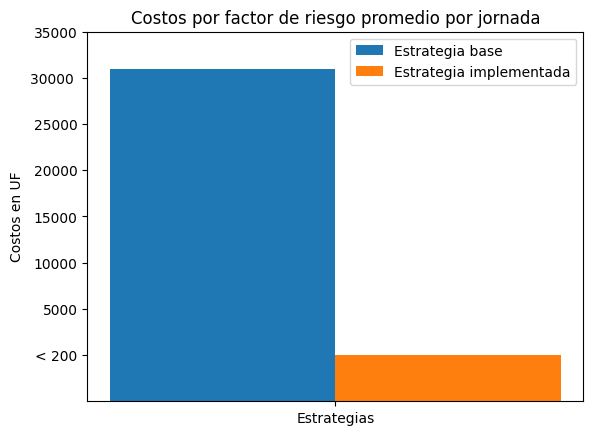

In [91]:
analisis.graficos_barras("Costos espera WL")

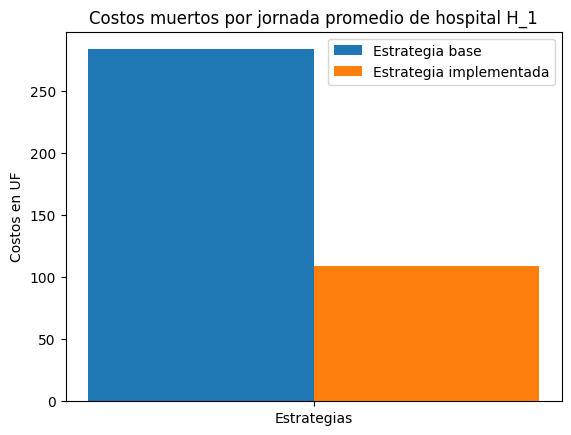

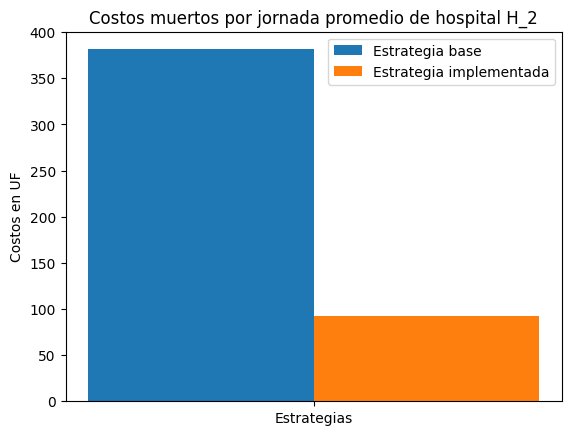

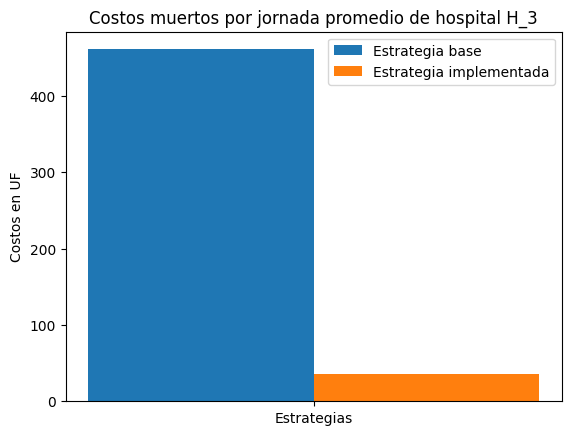

In [60]:
analisis.graficos_barras_estrategias("Costos muertos")

In [71]:
analisis.intervalo_confianza_tasas_ocupacion

{'Estrategia 1': {'ED': (4.613711649257327, 4.843361521474391),
  'GA': (nan, nan),
  'ICU': (68.79986868557641, 69.35193131442357),
  'OR': (30.789587178761042, 31.45263504346121),
  'SDU_WARD': (89.84834023796135, 89.96537404775289)},
 'Estrategia 2': {'ED': (1.6708039979120795, 1.8540740508684075),
  'GA': (79.01805994921577, 79.67860671745086),
  'ICU': (71.0747384336108, 71.5512615663892),
  'OR': (30.066569125523017, 30.654541985588125),
  'SDU_WARD': (88.45452607935543, 88.57424943084855)},
 'Estrategia 3': {'ED': (1.767534728310451, 1.9424652716895472),
  'GA': (79.06920693343876, 79.7532930665612),
  'ICU': (71.06328345525917, 71.67331654474081),
  'OR': (29.958007235786603, 30.52088165310233),
  'SDU_WARD': (88.49463126397275, 88.63598098092514)}}

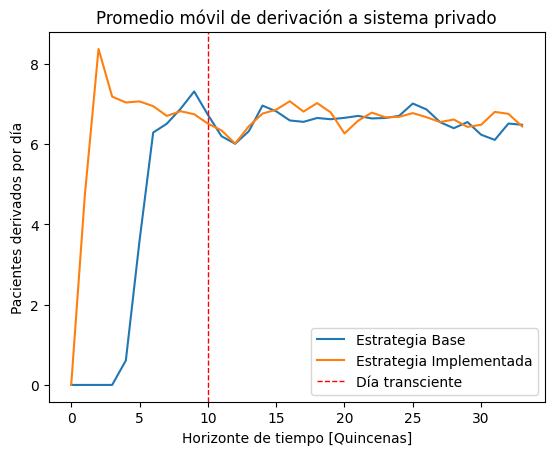

In [93]:
analisis.grafico_lineas_tiempo()

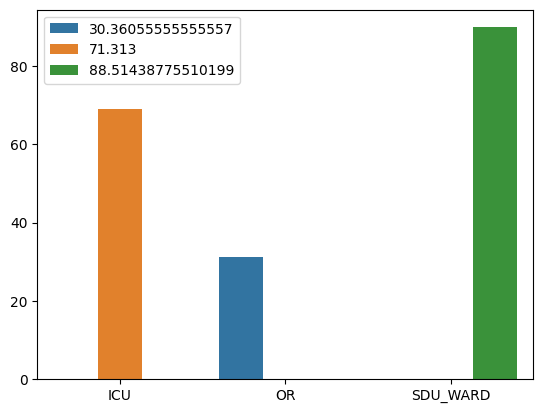

In [24]:
analisis.graficos_intervalos()

In [4]:
analisis.promedios

{'Estrategia 0': {'Costos jornada': 38085.911185285826,
  'Costos muertos': {'H_1': 283.4549260914695,
   'H_2': 381.45922066559586,
   'H_3': 460.9582196763586},
  'Costos derivaciones': {'H_1': 1907.141618243302,
   'H_2': 1287.5481053219044,
   'H_3': 625.4825640098082,
   'WL': 1917.2799040486236},
  'Costos espera WL': 31212.465704770802,
  'Costos traslados': {'H_1': 3.456131804701258,
   'H_2': 3.9123618143810286,
   'H_3': 2.7524288388848532},
  'Derivaciones': {'H_1': {'1': 0.5471,
    '2': 0.31170000000000003,
    '3': 0.36700000000000005,
    '4': 0.2143,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'H_2': {'1': 0.14550000000000002,
    '2': 0.3797,
    '3': 0.266,
    '4': 0.1917,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'H_3': {'1': 0.1376,
    '2': 0.039599999999999996,
    '3': 0.24539999999999995,
    '4': 0.12950000000000003,
    '5': 0.0,
    '6': 0.0,
    '7': 0.0,
    '8': 0.0},
   'WL': {'1': 0.0,
    '2': 0.0,
    '3': 0.0,
    '4

In [9]:
for estrategia in analisis.resultados_estrategias.keys():
    print(estrategia, analisis.promedios[estrategia]['Costos jornada'])
    print(estrategia, list(analisis.resultados_estrategias[estrategia]['Costos jornada'].values()))

Estrategia 0 38085.911185285826
Estrategia 0 38085.911185285826
Estrategia 7 5384.74582311711
Estrategia 7 5384.74582311711
Estrategia 6 5532.3346301676465
Estrategia 6 5532.3346301676465
Estrategia 5 5594.570976127342
Estrategia 5 5594.570976127342
Estrategia 4 5649.81163416713
Estrategia 4 5649.81163416713
Estrategia 3 5621.41192976654
Estrategia 3 5621.41192976654
Estrategia 2 5619.720999359055
Estrategia 2 5619.720999359055
Estrategia 1 5669.327456475297
Estrategia 1 5669.327456475297


In [115]:
mejor_estrategia = list(analisis.resultados_estrategias["Estrategia 7"]['Costos jornada'].values())
peor_estrategia = list(analisis.resultados_estrategias["Estrategia 0"]['Costos jornada'].values())
segunda_mejor_estrategia = list(analisis.resultados_estrategias["Estrategia 6"]['Costos jornada'].values())



In [160]:
analisis.intervalo_diferencias('Costos jornada', 'Estrategia 7', 'Estrategia 0')

[-33583.96010872154, -32514.306533635652, -32657.001993992806, -32745.832612124985, -34024.111110280384, -32669.062072185545, -33573.73852857719, -32033.559441646918, -31729.855904409837, -33452.412972956554, -31858.3954279413, -33912.952498665094, -32027.981457920396, -32419.495948971962, -31819.573938628182, -33000.97599376198, -32872.173330952246, -33748.033519901495, -33569.67531280467, -33315.45517385681, -34302.66393422167, -33365.62697603614, -34285.542489938176, -33625.05672776369, -32538.904004379896, -33169.71259164515, -33725.85129166602, -32776.0658146854, -31244.938356502513, -32403.507378032507, -33652.03449890394, -32697.93761502874, -33707.98867786864, -31876.47817203765, -32736.925137260074, -32891.317425150526, -31053.93488127627, -31347.872739268863, -33750.464530544225, -32661.113284798397, -33830.016061032744, -32439.72510364826, -32986.21132038113, -33043.23332943254, -30459.18535081283, -32001.968388615314, -33304.332967803726, -33014.12635987317, -34374.41115473

(-32888.73968816934, -32513.591036168094)

In [22]:
analisis.promedios['Estrategia 7']

{'Costos jornada': 5384.74582311711,
 'Costos muertos': {'H_1': 108.5949240814594,
  'H_2': 92.11307636037702,
  'H_3': 35.50810719994629},
 'Costos derivaciones': {'H_1': 342.625680424555,
  'H_2': 162.63518989116014,
  'H_3': 140.45150650789262,
  'WL': 4411.943008560554},
 'Costos espera WL': 84.13268015348065,
 'Costos traslados': {'H_1': 3.043231195002876,
  'H_2': 2.752966554010543,
  'H_3': 0.9454521886720917},
 'Derivaciones': {'H_1': {'1': 0.0932,
   '2': 0.0506,
   '3': 0.0816,
   '4': 0.0389,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_2': {'1': 0.0164,
   '2': 0.036399999999999995,
   '3': 0.06940000000000002,
   '4': 0.019299999999999998,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_3': {'1': 0.03119999999999999,
   '2': 0.009300000000000001,
   '3': 0.04579999999999998,
   '4': 0.029799999999999997,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'WL': {'1': 0.0,
   '2': 0.0,
   '3': 0.0,
   '4': 0.0,
   '5': 3.2651000000000003,
   '6': 2

In [71]:
analisis.promedios['Estrategia 7']['Tiempo de espera pacientes']

{'H_1': {'1': {'ICU': 0.35687385557486884,
   'SDU_WARD': 9.907794267972497,
   'OR': 0.09982060904178726,
   'GA': 0.0},
  '2': {'ICU': 0.5676866486196497,
   'SDU_WARD': 8.834326139775996,
   'OR': 0.023945563329771727,
   'GA': 0.0},
  '3': {'ICU': 0.411066323423116,
   'SDU_WARD': 3.512543681536353,
   'OR': 0.1351573788745941,
   'GA': 0.0},
  '4': {'ICU': 1.217513368513034,
   'SDU_WARD': 6.574237948795189,
   'OR': 0.1218743343419924,
   'GA': 0.0},
  '5': {'ICU': 0.9602735054838285,
   'SDU_WARD': 3.8353328686790915,
   'OR': 0.141142018492255,
   'GA': 0.0},
  '6': {'ICU': 1.675649935827903,
   'SDU_WARD': 1.0422750151068414,
   'OR': 0.3,
   'GA': 0.0},
  '7': {'ICU': 5.31791959467402,
   'SDU_WARD': 18.91160783814517,
   'OR': 1.054219876627111,
   'GA': 0.0},
  '8': {'ICU': 0.6131320199237814,
   'SDU_WARD': 0.0,
   'OR': 0.07108365050910995,
   'GA': 0.0}},
 'H_2': {'1': {'ICU': 0.5827346714409558,
   'SDU_WARD': 3.9260820730706074,
   'OR': 0.025766024372826258,
   'GA': 

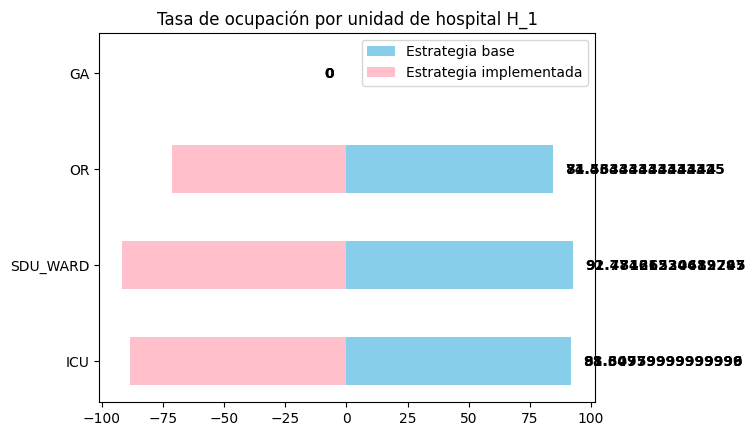

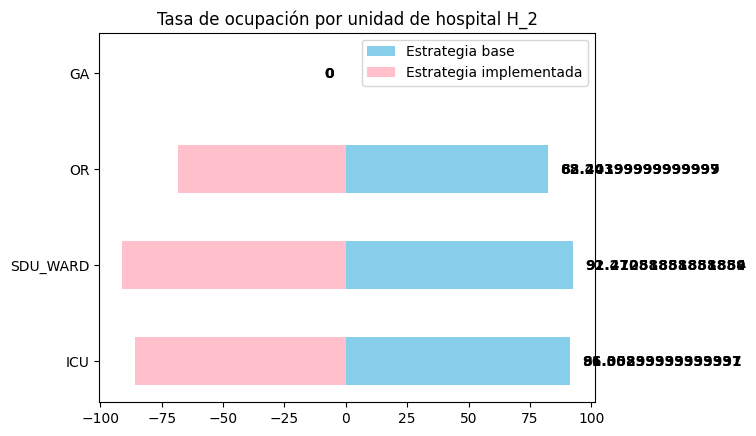

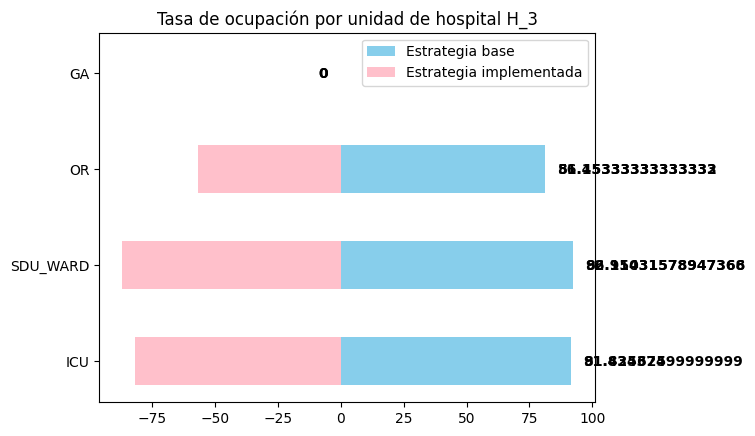

In [81]:
analisis.grafico_piramide('Tasas ocupación')

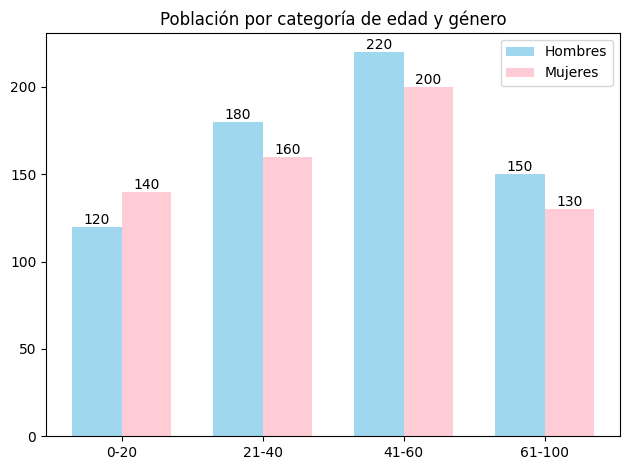

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
categorias_edad = ['0-20', '21-40', '41-60', '61-100']
hombres = [120, 180, 220, 150]  # Población masculina para cada categoría de edad
mujeres = [140, 160, 200, 130]  # Población femenina para cada categoría de edad

# Configuración del gráfico
bar_width = 0.35
opacity = 0.8

# Posiciones de las barras en el eje x
pos = np.arange(len(categorias_edad))

# Crear la figura y los subplots
fig, ax = plt.subplots()

# Graficar las barras para hombres
rects1 = ax.bar(pos, hombres, bar_width, alpha=opacity, color='skyblue', label='Hombres')

# Graficar las barras para mujeres
rects2 = ax.bar(pos + bar_width, mujeres, bar_width, alpha=opacity, color='pink', label='Mujeres')

# Configurar el eje x y la leyenda
ax.set_xticks(pos + bar_width / 2)
ax.set_xticklabels(categorias_edad)
ax.legend()

# Etiquetas de valor en las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, str(height), ha='center', va='bottom')

# Agregar las etiquetas de valor para hombres y mujeres
autolabel(rects1)
autolabel(rects2)

# Configurar el título
plt.title('Población por categoría de edad y género')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


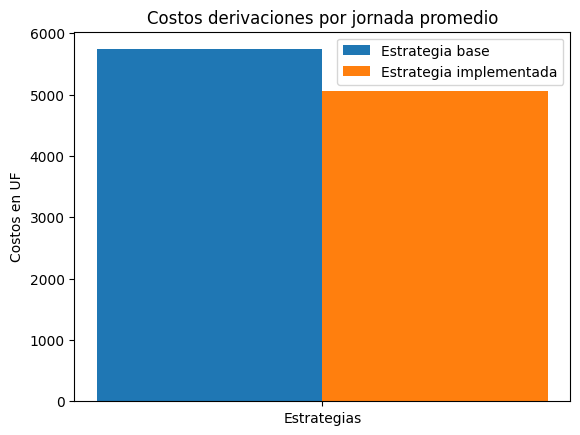

In [152]:
analisis.graficos_barras_particulares_estrategias("Costos derivaciones")

In [146]:
analisis.promedios['Estrategia 0']['Costos derivaciones']

{'H_1': 1907.141618243302,
 'H_2': 1287.5481053219044,
 'H_3': 625.4825640098082,
 'WL': 1917.2799040486236}

In [153]:
analisis.promedios['Estrategia 7']['Costos derivaciones']

{'H_1': 342.625680424555,
 'H_2': 162.63518989116014,
 'H_3': 140.45150650789262,
 'WL': 4411.943008560554}

In [154]:
analisis.promedios['Estrategia 7']['Costos jornada']

5384.74582311711

In [155]:
analisis.promedios['Estrategia 0']['Costos jornada']

38085.911185285826

In [156]:
analisis.desviaciones['Estrategia 7']['Costos jornada']

325.0334514846718

In [157]:
analisis.desviaciones['Estrategia 0']['Costos jornada']

883.5559919279688

In [158]:
analisis.intervalo_confianza['Estrategia 7']['Costos jornada']

(5320.71950128402, 5448.7721449502005)

In [159]:
analisis.intervalo_confianza['Estrategia 0']['Costos jornada']

(37911.86497546239, 38259.95739510926)

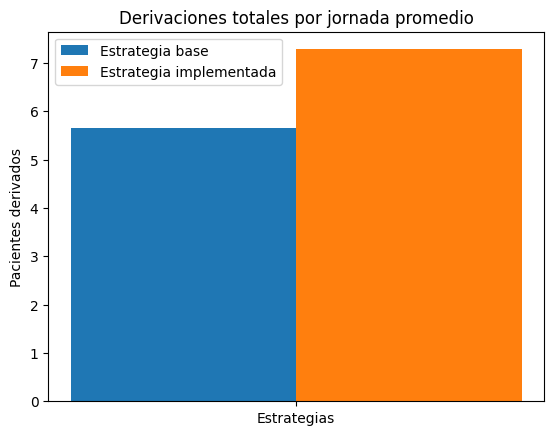

In [163]:
analisis.grafico_derivaciones_totales()

In [164]:
analisis.promedios['Estrategia 7']

{'Costos jornada': 5384.74582311711,
 'Costos muertos': {'H_1': 108.5949240814594,
  'H_2': 92.11307636037702,
  'H_3': 35.50810719994629},
 'Costos derivaciones': {'H_1': 342.625680424555,
  'H_2': 162.63518989116014,
  'H_3': 140.45150650789262,
  'WL': 4411.943008560554},
 'Costos espera WL': 84.13268015348065,
 'Costos traslados': {'H_1': 3.043231195002876,
  'H_2': 2.752966554010543,
  'H_3': 0.9454521886720917},
 'Derivaciones': {'H_1': {'1': 0.0932,
   '2': 0.0506,
   '3': 0.0816,
   '4': 0.0389,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_2': {'1': 0.0164,
   '2': 0.036399999999999995,
   '3': 0.06940000000000002,
   '4': 0.019299999999999998,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_3': {'1': 0.03119999999999999,
   '2': 0.009300000000000001,
   '3': 0.04579999999999998,
   '4': 0.029799999999999997,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'WL': {'1': 0.0,
   '2': 0.0,
   '3': 0.0,
   '4': 0.0,
   '5': 3.2651000000000003,
   '6': 2

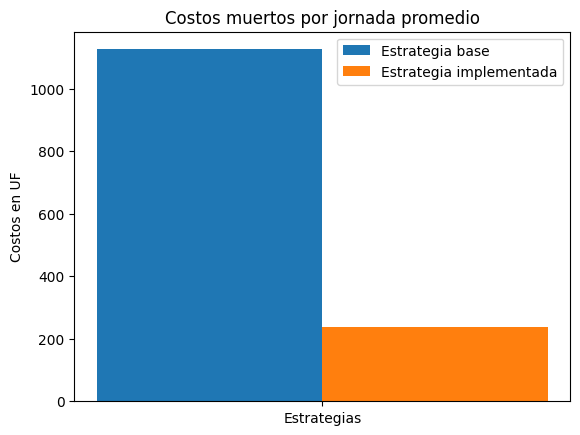

In [167]:
analisis.grafico_costos_muertos_totales()

In [168]:
analisis.promedios['Estrategia 7']

{'Costos jornada': 5384.74582311711,
 'Costos muertos': {'H_1': 108.5949240814594,
  'H_2': 92.11307636037702,
  'H_3': 35.50810719994629},
 'Costos derivaciones': {'H_1': 342.625680424555,
  'H_2': 162.63518989116014,
  'H_3': 140.45150650789262,
  'WL': 4411.943008560554},
 'Costos espera WL': 84.13268015348065,
 'Costos traslados': {'H_1': 3.043231195002876,
  'H_2': 2.752966554010543,
  'H_3': 0.9454521886720917},
 'Derivaciones': {'H_1': {'1': 0.0932,
   '2': 0.0506,
   '3': 0.0816,
   '4': 0.0389,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_2': {'1': 0.0164,
   '2': 0.036399999999999995,
   '3': 0.06940000000000002,
   '4': 0.019299999999999998,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_3': {'1': 0.03119999999999999,
   '2': 0.009300000000000001,
   '3': 0.04579999999999998,
   '4': 0.029799999999999997,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'WL': {'1': 0.0,
   '2': 0.0,
   '3': 0.0,
   '4': 0.0,
   '5': 3.2651000000000003,
   '6': 2

In [169]:
analisis.promedios['Estrategia 0']

{'Costos jornada': 38085.911185285826,
 'Costos muertos': {'H_1': 283.4549260914695,
  'H_2': 381.45922066559586,
  'H_3': 460.9582196763586},
 'Costos derivaciones': {'H_1': 1907.141618243302,
  'H_2': 1287.5481053219044,
  'H_3': 625.4825640098082,
  'WL': 1917.2799040486236},
 'Costos espera WL': 31212.465704770802,
 'Costos traslados': {'H_1': 3.456131804701258,
  'H_2': 3.9123618143810286,
  'H_3': 2.7524288388848532},
 'Derivaciones': {'H_1': {'1': 0.5471,
   '2': 0.31170000000000003,
   '3': 0.36700000000000005,
   '4': 0.2143,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_2': {'1': 0.14550000000000002,
   '2': 0.3797,
   '3': 0.266,
   '4': 0.1917,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'H_3': {'1': 0.1376,
   '2': 0.039599999999999996,
   '3': 0.24539999999999995,
   '4': 0.12950000000000003,
   '5': 0.0,
   '6': 0.0,
   '7': 0.0,
   '8': 0.0},
  'WL': {'1': 0.0,
   '2': 0.0,
   '3': 0.0,
   '4': 0.0,
   '5': 1.0098999999999998,
   '6': 0.8144000000

In [174]:
hospitales = ["H_1", "H_2", "H_3", "WL"]
suma_costos_implementada = 0
suma_costos_base = 0

for hospital in hospitales:
    suma_costos_base += analisis.promedios['Estrategia 0']['Costos derivaciones'][hospital]
    suma_costos_implementada += analisis.promedios['Estrategia 7']['Costos derivaciones'][hospital]

print(suma_costos_base)
print(suma_costos_implementada)

AttributeError: 'numpy.float64' object has no attribute 'keys'

In [175]:
analisis.promedios['Estrategia 0']['Costos derivaciones']

{'H_1': 1907.141618243302,
 'H_2': 1287.5481053219044,
 'H_3': 625.4825640098082,
 'WL': 1917.2799040486236}